# Tutorial

This notebook demonstrates the whole process of aligning audio files to a collection of transcripts.

The requirements for this process are:
* a collection of audio files
* a collection of human transcripts

The two collections above need not be corresponding to each other. We will merge all the transcripts together into one huge file and match the audio to the transcripts automatically.

As an example, we will download a sample MP3 roughly 15 minutes in length and a transcription file that contains much more text than the aforementioned audio. We will also download a language model used for initial speech recognition and some Kaldi models for aligning the matched transcript to the audio.

In [ ]:
!wget https://github.com/danijel3/ParlaSpeechAlignment/releases/download/data/sample.mp3
!wget https://github.com/danijel3/ParlaSpeechAlignment/releases/download/data/sample.txt
!wget https://github.com/danijel3/ParlaSpeechAlignment/releases/download/models/kaldi_models.tar.xz
!wget https://github.com/danijel3/ParlaSpeechAlignment/releases/download/models/lm.tar.xz
!tar xvf lm.tar.xz
!tar xvf kaldi_models.tar.xz

We need the files to be sampled at 16 kHz, mono and saved as a simple PCM wave file:

In [1]:
!sox sample.mp3 -r 16k -c 1 -e signed-integer sample.wav

This is what the file looks like after conversion:

In [2]:
!ffprobe -hide_banner sample.wav

Input #0, wav, from 'sample.wav':
  Duration: 00:15:00.05, bitrate: 256 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, 1 channels, s16, 256 kb/s


## VAD

The file cannot be processed when it's that long. We need to split it into smaller segments and to do that we will use Voice Activity Detection (VAD) in the form of this lovely Torch library:

In [3]:
import torch

vad_model, vad_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad')

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = vad_utils

Using cache found in /home/guest/.cache/torch/hub/snakers4_silero-vad_master


This is how VAD is applied to the audio:

In [4]:
wav = read_audio(f'sample.wav', sampling_rate=16000)
vad_ts = get_speech_timestamps(wav, vad_model, sampling_rate=16000, speech_pad_ms=1000, return_seconds=True)
print(f'Found {len(vad_ts)} segments')

Found 184 segments


Initially, we get lots of small segments, but we can merge them together if they are close to each other while making sure the final segments aren't longer than 30 seconds:

In [5]:
from utils import vad

vad_ts = vad.resample(vad_ts)
print(f'Reduced number of segments to {len(vad_ts)}')

Reduced number of segments to 36


We can draw a sample segment using Matplotlib:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

This graph shows a piece of audio roughly 30 seconds long:

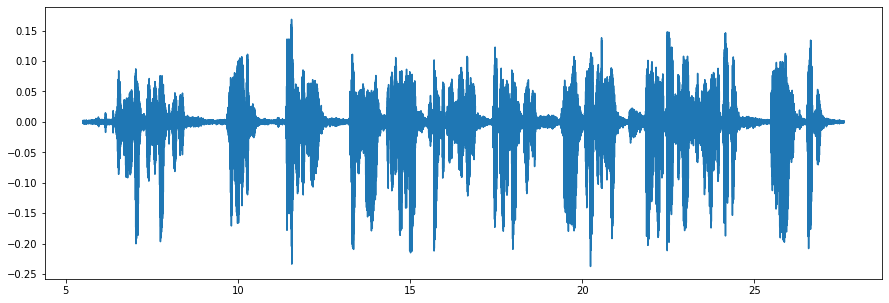

In [7]:
plt.figure(figsize=(15, 5))
beg = vad_ts[0]['start']
end = vad_ts[0]['end']
nb = int(beg * 16000)
ne = int(end * 16000)
plt.plot(np.linspace(beg, end, ne - nb), wav[nb:ne])

And this code allows us to listen to it:

In [8]:
Audio(wav[nb:ne], rate=16000)

## ASR

Now we can do an initial pass of an Automatic Speech Recognition (ASR) procedure. Here we will use a library that requires files to be saved on the drive. That is why we will save the above segment to a new file. The segment was automatically converted to float while reading, so we have to convert it back to 16-bit integers bewfore saving:

In [9]:
seg = (wav[nb:ne] * torch.iinfo(torch.int16).max).to(torch.int16)
save_audio('segment.wav', seg, sampling_rate=16000)

Now we can load the ASR models using the HuggingSound library. Due to a small incompatibility between the models and the library, we need to make a small hack with the `token_set`, but otherwise the model works fine. We will also use a language model that was trained on all the human transcripts:

In [10]:
from huggingsound import SpeechRecognitionModel, KenshoLMDecoder

model = SpeechRecognitionModel("classla/wav2vec2-xls-r-parlaspeech-hr")
model.token_set.tokens.pop(48)
decoder = KenshoLMDecoder(model.token_set, lm_path='lm.binary')

05/18/2022 00:03:03 - INFO - huggingsound.speech_recognition.model - Loading model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


05/18/2022 00:03:10 - WARNING - root - silence_token | not in provided tokens. It will be added to the list of tokens
05/18/2022 00:03:10 - WARNING - root - bos_token <s> not in provided tokens. It will be added to the list of tokens
05/18/2022 00:03:10 - WARNING - root - eos_token </s> not in provided tokens. It will be added to the list of tokens
05/18/2022 00:03:10 - WARNING - pyctcdecode.decoder - Unigrams not provided and cannot be automatically determined from LM file (only arpa format). Decoding accuracy might be reduced.
05/18/2022 00:03:10 - WARNING - pyctcdecode.alphabet - Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
05/18/2022 00:03:10 - WARNING - pyctcdecode.language_model - No known unigrams provided, decoding results might be a lot worse.


This is an example of how to recognize a single segment:

In [11]:
transcription = model.transcribe(['segment.wav'], decoder=decoder)
print(transcription[0]['transcription'])

100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

poštovane zastupnice i zastupnici zamolio bih prije nego se krene sa objašnjenjima stanke koje su uzeli poštovani zastupnici da omogućimo pravobraniteljici za osobe sa invaliditetom imenovanje dakle


We can obviously run this on many files. A utility script was created to process multiple audio files in parallel. It creates a `cache` directory where all the segments are temporarily stored. After the procedure is done, this folder can be purged. The results are dumped to a JSON list file:

In [12]:
from pathlib import Path
import json
from utils import recognition

res = recognition.process_files([Path('sample.wav')])

with open('asr_results.json', 'w') as f:
    for seg in res:
        f.write(json.dumps(seg) + '\n')

05/18/2022 00:03:14 - INFO - huggingsound.speech_recognition.model - Loading model...


Using cache found in /home/guest/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


05/18/2022 00:03:21 - WARNING - root - silence_token | not in provided tokens. It will be added to the list of tokens
05/18/2022 00:03:21 - WARNING - root - bos_token <s> not in provided tokens. It will be added to the list of tokens
05/18/2022 00:03:21 - WARNING - root - eos_token </s> not in provided tokens. It will be added to the list of tokens
05/18/2022 00:03:21 - WARNING - pyctcdecode.decoder - Unigrams not provided and cannot be automatically determined from LM file (only arpa format). Decoding accuracy might be reduced.
05/18/2022 00:03:21 - WARNING - pyctcdecode.alphabet - Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
05/18/2022 00:03:21 - WARNING - pyctcdecode.language_model - No known unigrams provided, decoding results might be a lot worse.


100%|██████████| 9/9 [02:49<00:00, 18.87s/it]


Here is a preview of that file:

In [6]:
!head asr_results.json

{"file": "sample.wav", "start": 5.5, "end": 27.6, "text": "po\u0161tovane zastupnice i zastupnici zamolio bih prije nego se krene sa obja\u0161njenjima stanke koje su uzeli po\u0161tovani zastupnici da omogu\u0107imo pravobraniteljice za osobe sa invaliditetom imenovanje dakle"}
{"file": "sample.wav", "start": 27.6, "end": 49.9, "text": "pri\u0161li bi davanju prisege pravobraniteljice za osobe s invaliditetom koju smo ju\u010der imenovali sla\u017eete li se hvala nakon \u0161to pro\u010ditam tekst prisege pravobraniteljica izgovara rije\u010d prise\u017eem tekst prisege glasi"}
{"file": "sample.wav", "start": 49.9, "end": 71.5, "text": "prise\u017eem da \u0107u se u svom radu dr\u017eati ustava i zakona po\u0161tovati pravni poredak republike hrvate i da \u0107u svoju du\u017enost obavljati pravi\u010dno \u010dasno savjesno i nepristrano u najboljem interesu osoba sa invaliditetom \u010destitam pravobraniteljici"}
{"file": "sample.wav", "start": 78.9, "end": 102.2, "text": "\u010desti

## Matching

Now we will attempt to match the ASR output to the large human transcript. The `Matcher` class is initialized with the large transcript and a `match` method can be used to match a sequence of ASR results. The output is a list of position objects containing the slices within both the reference and the ASR output:

In [13]:
from pathlib import Path
from utils.matching import Matcher, load_segments

matcher = Matcher(Path('sample.txt'))
asr_results = load_segments(Path('asr_results.json'))
positions = matcher.match(asr_results)

We have a small debug routine to observe the match results. Each segment is shown aligned with the human transcript and the ratio value is the quality of the match (wrt to the edit errors):

In [14]:
matcher.print_debug(positions)

Printing 36 segments:
CORPUS	poštovane	zastupnice	i	zastupnici	zamolio	bih	prije	nego	se	krene	sa	objašnjenjima	stanke	koju	su	uzeli	poštovani	zastupnici	da	omogućimo	pravobraniteljici	za	osobe	s	invaliditetom	imenovanje	dakle	prišli	bi	davali	prisege	pravobraniteljice	za	osobe	s	invaliditetom
SEGMENT	poštovane	zastupnice	i	zastupnici	zamolio	bih	prije	nego	se	krene	sa	objašnjenjima	stanke	koje	su	uzeli	poštovani	zastupnici	da	omogućimo	pravobraniteljice	za	osobe	sa	invaliditetom	imenovanje	dakle
RATIO 	 0.7619047619047619
--------------
CORPUS	koju	smo	jučer	imenovali	slažete	li	se	hvala	nakon	što	pročitam	tekst	priseže	pravobraniteljica	izgovara	riječ	prisežem	tekst	prisege	glasi
SEGMENT	koju	smo	jučer	imenovali	slažete	li	se	hvala	nakon	što	pročitam	tekst	prisege	pravobraniteljica	izgovara	riječ	prisežem	tekst	prisege	glasi
RATIO 	 0.7755102040816326
--------------
CORPUS	prisežem	da	ću	se	u	svom	radu	držati	ustava	i	zakona	poštovati	pravni	poredak	erha	i	da	ću	svoju	dužnost	obavlja

There are still some errors above, that is why we will merge a bunch of consecutive segments together and use Kaldi to force re-align everything. We use Kaldi for this because it has fewer issues with working on large audio files. Although it's WER may be slightly worse than the above HuggingSound example, the alignment is generally good enough and works well. Here we merge the segments into larger chunks:

In [15]:
positions = matcher.resegment_positions(positions)
matcher.print_debug(positions)

Printing 2 segments:
CORPUS	poštovane	zastupnice	i	zastupnici	zamolio	bih	prije	nego	se	krene	sa	objašnjenjima	stanke	koju	su	uzeli	poštovani	zastupnici	da	omogućimo	pravobraniteljici	za	osobe	s	invaliditetom	imenovanje	dakle	prišli	bi	davali	prisege	pravobraniteljice	za	osobe	s	invaliditetom	koju	smo	jučer	imenovali	slažete	li	se	hvala	nakon	što	pročitam	tekst	priseže	pravobraniteljica	izgovara	riječ	prisežem	tekst	prisege	glasi	prisežem	da	ću	se	u	svom	radu	držati	ustava	i	zakona	poštovati	pravni	poredak	erha	i	da	ću	svoju	dužnost	obavljati	pravično	časno	savjesno	i	nepristrano	u	najboljem	interesu	osoba	s	invaliditetom	prisežem	čestitam	pravobraniteljici
SEGMENT	poštovane	zastupnice	i	zastupnici	zamolio	bih	prije	nego	se	krene	sa	objašnjenjima	stanke	koje	su	uzeli	poštovani	zastupnici	da	omogućimo	pravobraniteljice	za	osobe	sa	invaliditetom	imenovanje	dakle	prišli	bi	davanju	prisege	pravobraniteljice	za	osobe	s	invaliditetom	koju	smo	jučer	imenovali	slažete	li	se	hvala	nakon	što	pro

## Re-alignment

We will create a temporary work directory. Using the above list of segments, we will create some files in the data dir of that work directory:

In [16]:
%mkdir work
%mkdir work/data
matcher.make_kaldi_dir(positions, Path('work/data'), Path('.'))

Here we will create the rest of the required files for the data dir. The `utt2spk` and `spk2utt` will simply assume each segment is a different speaker (for lack of a better solution) and the `reco2file_and_channel` will simply highlight that all the files are mono:

In [17]:
%%bash
cut -f1 -d' ' work/data/segments | awk '{print $1,$1}' > work/data/utt2spk
cut -f1 -d' ' work/data/wav.scp | awk '{print $1,$1,"A"}' > work/data/reco2file_and_channel
cp work/data/utt2spk work/data/spk2utt
export LC_ALL=C
for f in work/data/* ; do
    sort -o $f $f
done

Next we will run the alignment procedure. This assumes Kaldi is installed in `/opt/kaldi` on the host system. Take a look at the script for more details:

In [18]:
!./utils/kaldi_align.sh

./steps/make_mfcc.sh --nj 2 --mfcc-config conf/mfcc_hires.conf data
utils/validate_data_dir.sh: Successfully validated data-directory data
./steps/make_mfcc.sh [info]: segments file exists: using that.
./steps/make_mfcc.sh: Succeeded creating MFCC features for data
./steps/compute_cmvn_stats.sh data
Succeeded creating CMVN stats for data
./steps/online/nnet2/extract_ivectors_online.sh --nj 2 data exp/nnet3/extractor ivectors
filter_scps.pl: warning: some input lines were output to multiple files [OK if splitting per utt] 
filter_scps.pl: warning: some input lines were output to multiple files [OK if splitting per utt] 
./steps/online/nnet2/extract_ivectors_online.sh: extracting iVectors
./steps/online/nnet2/extract_ivectors_online.sh: combining iVectors across jobs
./steps/online/nnet2/extract_ivectors_online.sh: done extracting (online) iVectors to ivectors using the extractor in exp/nnet3/extractor.
./utils/prepare_lang.sh dict <unk> tmp lang
Checking dict/silence_phones.txt ...
--> 

The final result of the script is a CTM file stored in the `work/ali` dir. Here is a preview of that file:

In [7]:
!head work/ali/ctm

reco000 A 6.38 0.54 poštovane
reco000 A 6.92 0.67 zastupnice
reco000 A 7.59 0.03 i
reco000 A 7.62 0.88 zastupnici
reco000 A 9.65 0.52 zamolio
reco000 A 10.17 0.34 bih
reco000 A 11.33 0.31 prije
reco000 A 11.64 0.30 nego
reco000 A 11.94 0.59 se
reco000 A 13.20 0.34 krene


It contains a list of words and their location within the file. We will load this file and convert it into 20 second segments again:

In [2]:
from pathlib import Path
from utils.matching import ctm_to_segments

segments = ctm_to_segments(Path('work/data/wav.scp'), Path('work/ali/ctm'))
print(f'Created {len(segments)} segments...')

Created 54 segments...


The segments are dumped into a JSON list file again:

In [4]:
import json
with open('final_segments.json', 'w') as f:
    for seg in segments:
        f.write(json.dumps(seg.to_dict()) + '\n')

This is the preview of the final segment list:

In [5]:
!head final_segments.json

{"file": "/home/guest/PycharmProjects/ParlaSpeechAlignment/sample.wav", "start": 6.38, "end": 8.5, "text": ["po\u0161tovane", "zastupnice", "i", "zastupnici"]}
{"file": "/home/guest/PycharmProjects/ParlaSpeechAlignment/sample.wav", "start": 9.65, "end": 26.95, "text": ["zamolio", "bih", "prije", "nego", "se", "krene", "sa", "obja\u0161njenjima", "stanke", "koju", "su", "uzeli", "po\u0161tovani", "zastupnici", "da", "omogu\u0107imo", "pravobraniteljici", "za", "osobe", "s", "invaliditetom", "imenovanje", "dakle"]}
{"file": "/home/guest/PycharmProjects/ParlaSpeechAlignment/sample.wav", "start": 27.96, "end": 46.64, "text": ["pri\u0161li", "bi", "davali", "prisege", "pravobraniteljice", "za", "osobe", "s", "invaliditetom", "koju", "smo", "ju\u010der", "imenovali", "sla\u017eete", "li", "se", "hvala", "nakon", "\u0161to", "pro\u010ditam", "tekst", "prise\u017ee", "pravobraniteljica", "izgovara", "rije\u010d", "prise\u017eem"]}
{"file": "/home/guest/PycharmProjects/ParlaSpeechAlignment/samp